In [1]:
x=1

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

# across CV folds

## mtm embedding, classification model

In [3]:
adata = sc.read('../../../pipeline/data/multigrate_mil/pbmc_mtg_final1/c1d69bdf7d_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

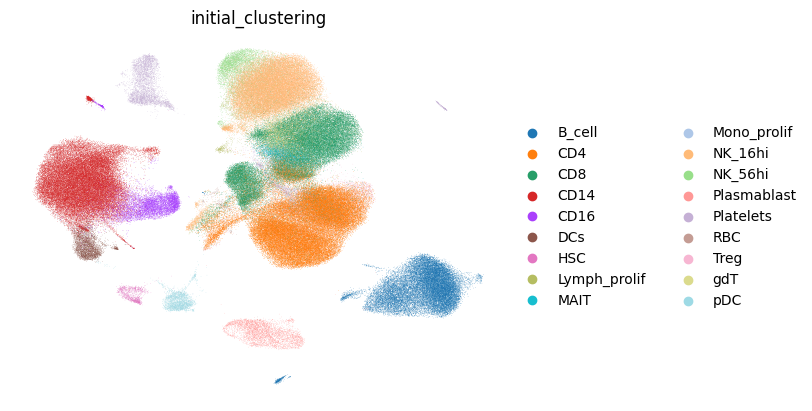

In [4]:
sc.pl.umap(adata, color='initial_clustering', frameon=False, ncols=1)

In [5]:
for i in range(5):
    threshold_idx = int(len(adata) * 0.9)
    threshold_value = sorted(adata.obs[f'cell_attn_{i}'])[threshold_idx]
    adata.obs[f'group_{i}'] = 'all cells'
    adata.obs.loc[adata.obs[f'cell_attn_{i}'] >= threshold_value, f'group_{i}'] = 'top 10% cells'
    adata.obs[f'top_cells_{i}'] = False
    adata.obs.loc[adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs_names, f'top_cells_{i}'] = True
    adata.obs[f'top_cells_{i}'] = adata.obs[f'top_cells_{i}'].astype('category')

In [6]:
dfs = []
for i in range(5):
    df_tmp = adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs[['initial_clustering']]
    df_tmp.loc[:, 'fold'] = f'fold_{i}'
    dfs.append(df_tmp)
df = pd.concat(dfs)
df

,initial_clustering,fold
covid_index,,
AAACCTGGTCTAGTCA-newcastle65,DCs,fold_0
AAACCTGTCCGTAGGC-newcastle65,CD4,fold_0
AAACGGGAGATAGCAT-newcastle65,CD14,fold_0
AAACGGGAGCACAGGT-newcastle65,CD14,fold_0
AAACGGGCATAGTAAG-newcastle65,CD14,fold_0
...,...,...
BGCV15_TTGGCAAAGTACATGA-1,CD4,fold_4
BGCV15_TTGTAGGCACCATCCT-1,CD4,fold_4
BGCV15_TTTGCGCAGCGAAGGG-1,CD4,fold_4


In [7]:
df_sort = df['initial_clustering'].value_counts().sort_values(ascending=False)
df_sort

CD14            54556
CD16            24496
CD4              9931
B_cell           8415
Plasmablast      8336
CD8              6659
NK_16hi          5666
DCs              2474
Platelets        1401
NK_56hi          1247
Treg             1206
gdT              1190
MAIT              602
Lymph_prolif      548
HSC               470
RBC               423
pDC               267
Mono_prolif       143
Name: initial_clustering, dtype: int64

In [8]:
df_group = df.groupby('fold').value_counts(normalize=True).mul(100)
df_group

fold    initial_clustering
fold_0  CD14                  43.778802
        CD16                  23.545263
        Plasmablast            8.228540
        CD8                    5.194095
        B_cell                 4.592674
                                ...    
fold_4  RBC                    0.164024
        MAIT                   0.128876
        Lymph_prolif           0.117160
        pDC                    0.054675
        gdT                    0.039053
Length: 90, dtype: float64

In [9]:
color = []
for ct in df_sort.index:
    idx = list(adata.obs['initial_clustering'].cat.categories).index(ct)
    color.append(adata.uns['initial_clustering_colors'][idx])
len(color)

18

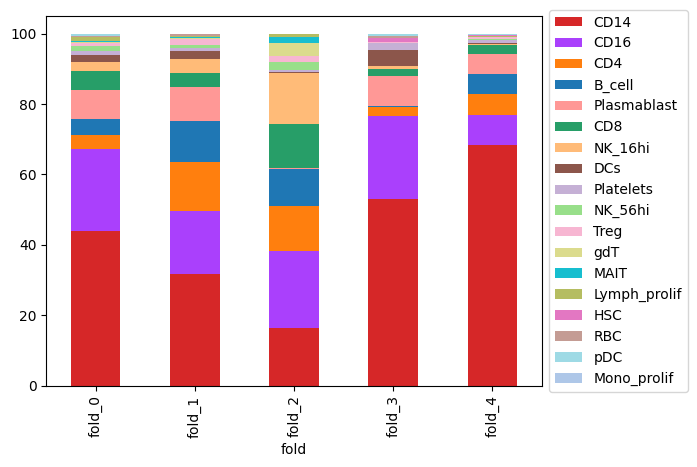

In [10]:
df_group.unstack()[list(df_sort.index)].plot.bar(stacked=True, color=color).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.savefig('figures/attn_robustness_across_folds_mtm.svg', bbox_inches='tight')

## mtm embedding, regression model

In [11]:
adata = sc.read('../../../pipeline/data/multigrate_mil_reg/pbmc_mtg_final1/d31255f30e_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

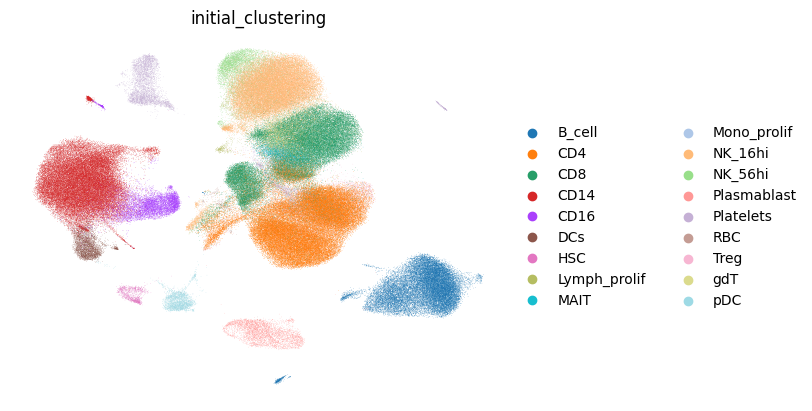

In [12]:
sc.pl.umap(adata, color='initial_clustering', frameon=False, ncols=1)

In [13]:
for i in range(5):
    threshold_idx = int(len(adata) * 0.9)
    threshold_value = sorted(adata.obs[f'cell_attn_{i}'])[threshold_idx]
    adata.obs[f'group_{i}'] = 'all cells'
    adata.obs.loc[adata.obs[f'cell_attn_{i}'] >= threshold_value, f'group_{i}'] = 'top 10% cells'
    adata.obs[f'top_cells_{i}'] = False
    adata.obs.loc[adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs_names, f'top_cells_{i}'] = True
    adata.obs[f'top_cells_{i}'] = adata.obs[f'top_cells_{i}'].astype('category')

In [14]:
dfs = []
for i in range(5):
    df_tmp = adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs[['initial_clustering']]
    df_tmp.loc[:, 'fold'] = f'fold_{i}'
    dfs.append(df_tmp)
df = pd.concat(dfs)
df

,initial_clustering,fold
covid_index,,
AAACCTGTCCGTAGGC-newcastle65,CD4,fold_0
AAAGCAAAGGGTCTCC-newcastle65,DCs,fold_0
AAATGCCAGTACGTTC-newcastle65,CD16,fold_0
AAATGCCTCTGACCTC-newcastle65,CD8,fold_0
AACACGTGTCCTCTTG-newcastle65,NK_56hi,fold_0
...,...,...
BGCV15_TAGTGGTCATAAGACA-1,CD8,fold_4
BGCV15_TCTATTGTCCGAAGAG-1,CD8,fold_4
BGCV15_TCTTCGGTCCTTCAAT-1,Platelets,fold_4


In [15]:
df_sort = df['initial_clustering'].value_counts().sort_values(ascending=False)
df_sort

CD14            29163
B_cell          24107
CD4             13437
NK_16hi         11968
Plasmablast      9676
CD8              9560
Platelets        9037
CD16             8776
DCs              3357
Treg             3195
Lymph_prolif     1744
RBC              1080
NK_56hi           816
pDC               672
gdT               636
MAIT              373
HSC               307
Mono_prolif       126
Name: initial_clustering, dtype: int64

In [16]:
df_group = df.groupby('fold').value_counts(normalize=True).mul(100)
df_group

fold    initial_clustering
fold_0  CD14                  15.906428
        NK_16hi               15.465125
        CD16                  14.656721
        CD4                    9.903929
        DCs                    9.806295
                                ...    
fold_4  pDC                    0.339764
        gdT                    0.281184
        MAIT                   0.226509
        B_cell                 0.121065
        NK_56hi                0.011716
Length: 90, dtype: float64

In [17]:
color = []
for ct in df_sort.index:
    idx = list(adata.obs['initial_clustering'].cat.categories).index(ct)
    color.append(adata.uns['initial_clustering_colors'][idx])
len(color)

18

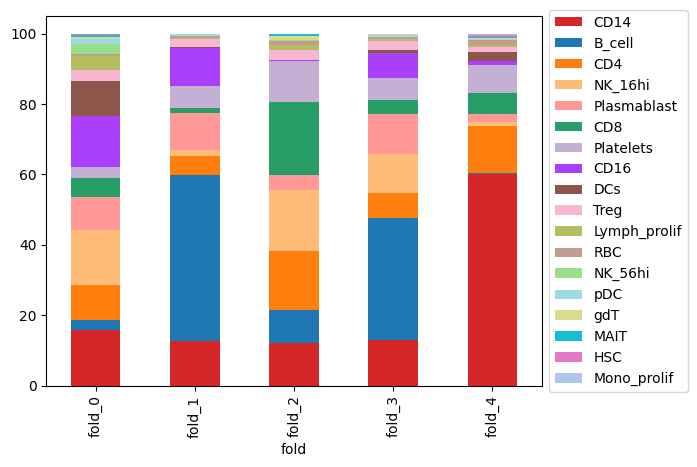

In [18]:
df_group.unstack()[list(df_sort.index)].plot.bar(stacked=True, color=color).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.savefig('figures/attn_robustness_across_folds_mtm_reg.svg', bbox_inches='tight')

## totalvi embedding, classification model

In [19]:
adata = sc.read('../../../pipeline/data/multigrate_mil/totalvi_pbmc_embed_3_cond_balanced/79bf894609_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', '_scvi_labels', '_scvi_batch', 'group', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

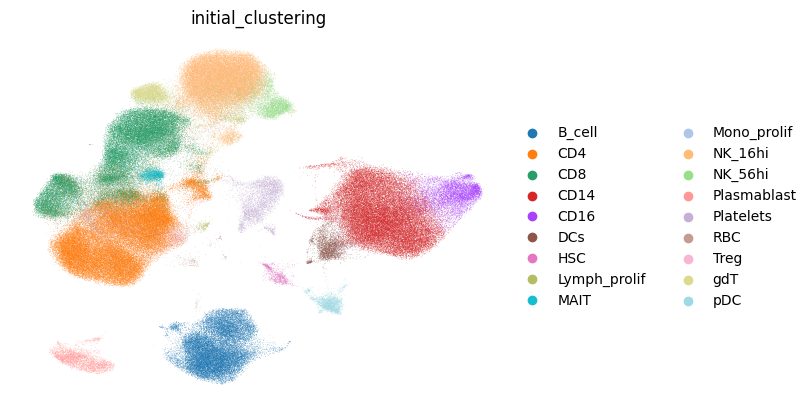

In [20]:
sc.pl.umap(adata, color='initial_clustering', frameon=False, ncols=1)

In [21]:
for i in range(5):
    threshold_idx = int(len(adata) * 0.9)
    threshold_value = sorted(adata.obs[f'cell_attn_{i}'])[threshold_idx]
    adata.obs[f'group_{i}'] = 'all cells'
    adata.obs.loc[adata.obs[f'cell_attn_{i}'] >= threshold_value, f'group_{i}'] = 'top 10% cells'
    adata.obs[f'top_cells_{i}'] = False
    adata.obs.loc[adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs_names, f'top_cells_{i}'] = True
    adata.obs[f'top_cells_{i}'] = adata.obs[f'top_cells_{i}'].astype('category')

In [22]:
dfs = []
for i in range(5):
    df_tmp = adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs[['initial_clustering']]
    df_tmp.loc[:, 'fold'] = f'fold_{i}'
    dfs.append(df_tmp)
df = pd.concat(dfs)
df

,initial_clustering,fold
covid_index,,
AAACGGGAGATAGCAT-newcastle65,CD14,fold_0
AAACGGGAGCACAGGT-newcastle65,CD14,fold_0
AAAGCAAAGGGTCTCC-newcastle65,DCs,fold_0
AAAGCAAGTCTTGTCC-newcastle65,CD14,fold_0
AAAGTAGAGATGCCAG-newcastle65,DCs,fold_0
...,...,...
BGCV15_TTAGGCACATCCGCGA-1,Platelets,fold_4
BGCV15_TTCGAAGGTTCCCGAG-1,B_cell,fold_4
BGCV15_TTCTTAGCAATCCGAT-1,CD4,fold_4


In [23]:
df_sort = df['initial_clustering'].value_counts().sort_values(ascending=False)
df_sort

CD14            57650
CD16            23088
CD4              8439
Plasmablast      7243
CD8              6937
NK_16hi          6082
Platelets        5978
B_cell           3101
DCs              2472
MAIT             2112
gdT              1829
Treg              723
RBC               723
Lymph_prolif      551
Mono_prolif       426
HSC               340
NK_56hi           239
pDC                97
Name: initial_clustering, dtype: int64

In [24]:
df_group = df.groupby('fold').value_counts(normalize=True).mul(100)
df_group

fold    initial_clustering
fold_0  CD14                  46.977271
        CD16                  18.163712
        CD8                    9.501679
        NK_16hi                7.818480
        Platelets              4.928532
                                ...    
fold_4  NK_56hi                0.300711
        DCs                    0.187456
        B_cell                 0.140592
        HSC                    0.046864
        pDC                    0.003905
Length: 89, dtype: float64

In [25]:
color = []
for ct in df_sort.index:
    idx = list(adata.obs['initial_clustering'].cat.categories).index(ct)
    color.append(adata.uns['initial_clustering_colors'][idx])
len(color)

18

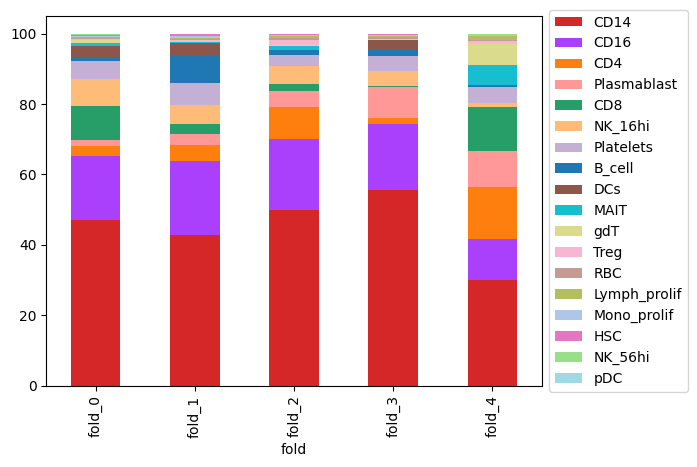

In [26]:
df_group.unstack()[list(df_sort.index)].plot.bar(stacked=True, color=color).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.savefig('figures/attn_robustness_across_folds_totalvi.svg', bbox_inches='tight')

## totalvi embedding, regresison model

In [27]:
adata = sc.read('../../../pipeline/data/multigrate_mil_reg/totalvi_pbmc_embed_3_cond_balanced/86043c5843_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', '_scvi_labels', '_scvi_batch', 'group', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

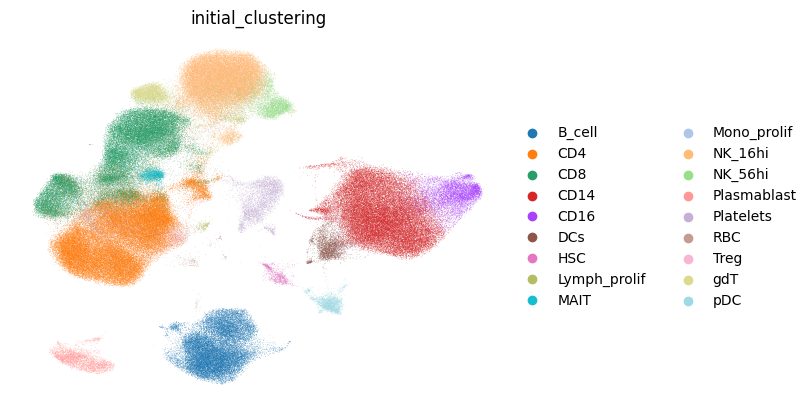

In [28]:
sc.pl.umap(adata, color='initial_clustering', frameon=False, ncols=1)

In [29]:
for i in range(5):
    threshold_idx = int(len(adata) * 0.9)
    threshold_value = sorted(adata.obs[f'cell_attn_{i}'])[threshold_idx]
    adata.obs[f'group_{i}'] = 'all cells'
    adata.obs.loc[adata.obs[f'cell_attn_{i}'] >= threshold_value, f'group_{i}'] = 'top 10% cells'
    adata.obs[f'top_cells_{i}'] = False
    adata.obs.loc[adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs_names, f'top_cells_{i}'] = True
    adata.obs[f'top_cells_{i}'] = adata.obs[f'top_cells_{i}'].astype('category')

In [30]:
dfs = []
for i in range(5):
    df_tmp = adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs[['initial_clustering']]
    df_tmp.loc[:, 'fold'] = f'fold_{i}'
    dfs.append(df_tmp)
df = pd.concat(dfs)
df

,initial_clustering,fold
covid_index,,
AAACGGGAGCACAGGT-newcastle65,CD14,fold_0
AAAGCAAAGGGTCTCC-newcastle65,DCs,fold_0
AAATGCCGTGTCAATC-newcastle65,CD16,fold_0
AACACGTCAGATTGCT-newcastle65,CD14,fold_0
AACACGTGTATGCTTG-newcastle65,CD14,fold_0
...,...,...
BGCV15_TTAGTTCTCTCGGACG-1,NK_16hi,fold_4
BGCV15_TTCTCCTTCAGCAACT-1,CD4,fold_4
BGCV15_TTGTAGGCACCATCCT-1,CD4,fold_4


In [31]:
df_sort = df['initial_clustering'].value_counts().sort_values(ascending=False)
df_sort

CD14            48354
CD16            25130
CD4             12449
Plasmablast      7772
CD8              7132
B_cell           6221
NK_16hi          6035
DCs              4438
Platelets        3768
gdT              1769
MAIT             1285
Treg              937
RBC               665
Lymph_prolif      594
Mono_prolif       481
pDC               408
NK_56hi           316
HSC               276
Name: initial_clustering, dtype: int64

In [32]:
df_group = df.groupby('fold').value_counts(normalize=True).mul(100)
df_group

fold    initial_clustering
fold_0  CD14                  34.878544
        CD16                  19.655549
        B_cell                14.902757
        CD4                   11.376240
        Plasmablast            5.838475
                                ...    
fold_4  RBC                    0.413965
        Mono_prolif            0.347575
        NK_56hi                0.101539
        pDC                    0.050769
        HSC                    0.003905
Length: 90, dtype: float64

In [33]:
color = []
for ct in df_sort.index:
    idx = list(adata.obs['initial_clustering'].cat.categories).index(ct)
    color.append(adata.uns['initial_clustering_colors'][idx])
len(color)

18

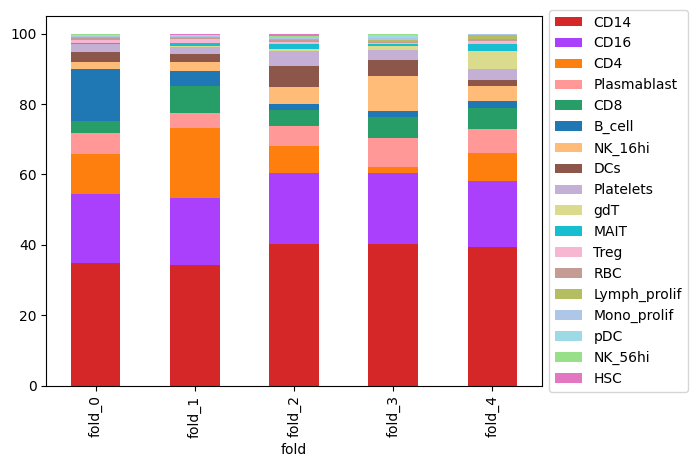

In [34]:
df_group.unstack()[list(df_sort.index)].plot.bar(stacked=True, color=color).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.savefig('figures/attn_robustness_across_folds_totalvi_reg.svg', bbox_inches='tight')

# across seeds

## random seed 42

In [35]:
adata = sc.read('../../../pipeline/data/multigrate_mil/pbmc_mtg_final1/aaf39a9e4c_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

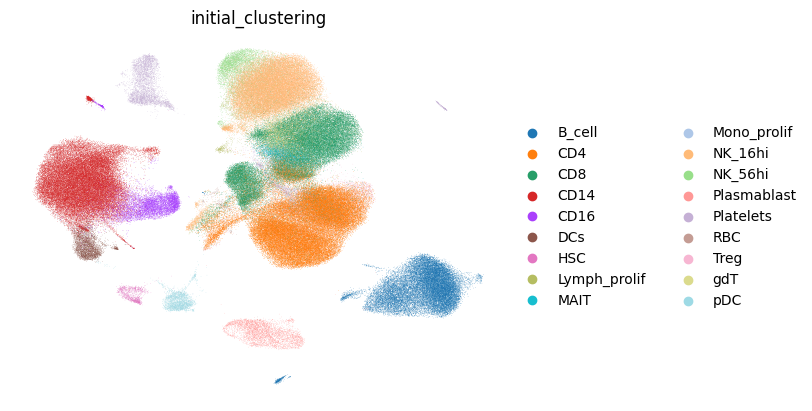

In [36]:
sc.pl.umap(adata, color='initial_clustering', frameon=False, ncols=1)

In [37]:
for i in range(5):
    threshold_idx = int(len(adata) * 0.9)
    threshold_value = sorted(adata.obs[f'cell_attn_{i}'])[threshold_idx]
    adata.obs[f'group_{i}'] = 'all cells'
    adata.obs.loc[adata.obs[f'cell_attn_{i}'] >= threshold_value, f'group_{i}'] = 'top 10% cells'
    adata.obs[f'top_cells_{i}'] = False
    adata.obs.loc[adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs_names, f'top_cells_{i}'] = True
    adata.obs[f'top_cells_{i}'] = adata.obs[f'top_cells_{i}'].astype('category')

In [38]:
dfs = []
for i in range(5):
    df_tmp = adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs[['initial_clustering']]
    df_tmp.loc[:, 'fold'] = f'fold_{i}'
    dfs.append(df_tmp)
df = pd.concat(dfs)
df

,initial_clustering,fold
covid_index,,
AAACGGGAGCACAGGT-newcastle65,CD14,fold_0
AAACGGGCATAGTAAG-newcastle65,CD14,fold_0
AAAGTAGAGATGCCAG-newcastle65,DCs,fold_0
AAATGCCGTGTCAATC-newcastle65,CD16,fold_0
AAATGCCTCGGTTAAC-newcastle65,CD14,fold_0
...,...,...
BGCV15_TTTCCTCTCTGATACG-1,CD4,fold_4
BGCV15_TTTCCTCTCTTTAGGG-1,CD4,fold_4
BGCV15_TTTGCGCAGCGAAGGG-1,CD4,fold_4


In [39]:
df_sort = df['initial_clustering'].value_counts().sort_values(ascending=False)
df_sort

CD14            57262
CD16            24582
CD4             12844
Plasmablast      7356
B_cell           6675
CD8              6123
NK_16hi          3204
Platelets        3151
DCs              2588
Treg             1369
Lymph_prolif      665
HSC               508
RBC               390
NK_56hi           357
gdT               306
MAIT              272
pDC               225
Mono_prolif       153
Name: initial_clustering, dtype: int64

In [40]:
df_group = df.groupby('fold').value_counts(normalize=True).mul(100)
df_group

fold    initial_clustering
fold_0  CD14                  55.190190
        CD16                  21.315317
        Plasmablast            7.345935
        B_cell                 5.010544
        CD8                    4.155276
                                ...    
fold_4  gdT                    0.324143
        RBC                    0.269468
        HSC                    0.222604
        Mono_prolif            0.160119
        pDC                    0.152308
Length: 90, dtype: float64

In [41]:
color = []
for ct in df_sort.index:
    idx = list(adata.obs['initial_clustering'].cat.categories).index(ct)
    color.append(adata.uns['initial_clustering_colors'][idx])
len(color)

18

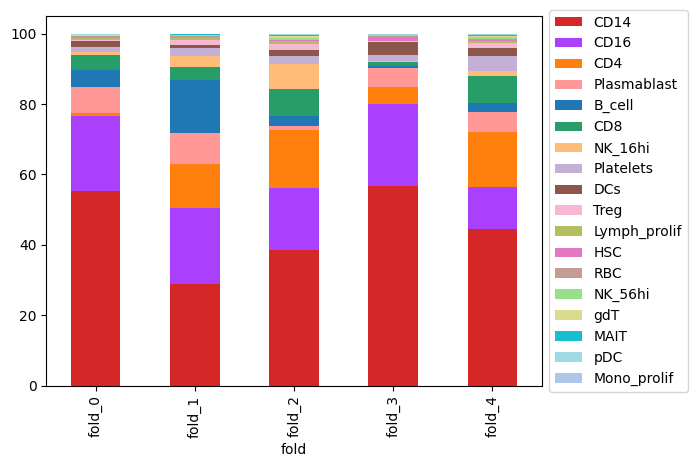

In [42]:
df_group.unstack()[list(df_sort.index)].plot.bar(stacked=True, color=color).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.savefig('figures/attn_robustness_across_folds_mtm_seed_42.svg', bbox_inches='tight')

## random seed 123

In [43]:
adata = sc.read('../../../pipeline/data/multigrate_mil/pbmc_mtg_final1/12b8899dbf_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

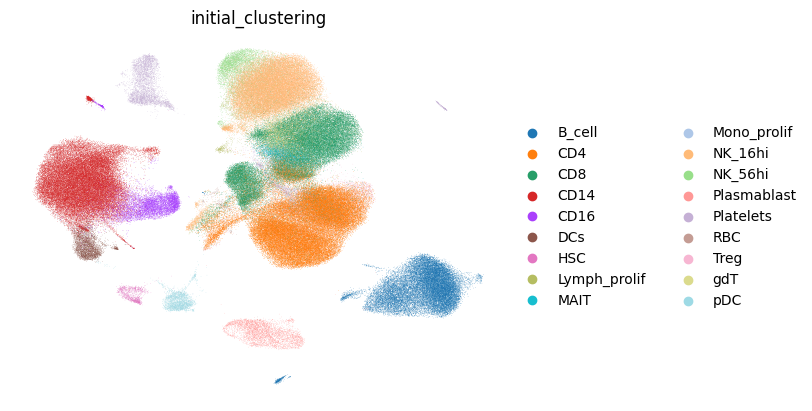

In [44]:
sc.pl.umap(adata, color='initial_clustering', frameon=False, ncols=1)

In [45]:
for i in range(5):
    threshold_idx = int(len(adata) * 0.9)
    threshold_value = sorted(adata.obs[f'cell_attn_{i}'])[threshold_idx]
    adata.obs[f'group_{i}'] = 'all cells'
    adata.obs.loc[adata.obs[f'cell_attn_{i}'] >= threshold_value, f'group_{i}'] = 'top 10% cells'
    adata.obs[f'top_cells_{i}'] = False
    adata.obs.loc[adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs_names, f'top_cells_{i}'] = True
    adata.obs[f'top_cells_{i}'] = adata.obs[f'top_cells_{i}'].astype('category')

In [46]:
dfs = []
for i in range(5):
    df_tmp = adata[adata.obs[f'group_{i}'] == 'top 10% cells'].obs[['initial_clustering']]
    df_tmp.loc[:, 'fold'] = f'fold_{i}'
    dfs.append(df_tmp)
df = pd.concat(dfs)
df

,initial_clustering,fold
covid_index,,
AAACGGGAGATAGCAT-newcastle65,CD14,fold_0
AAACGGGAGCACAGGT-newcastle65,CD14,fold_0
AAACGGGCATAGTAAG-newcastle65,CD14,fold_0
AAATGCCAGTACGTTC-newcastle65,CD16,fold_0
AAATGCCCAGACGCCT-newcastle65,DCs,fold_0
...,...,...
BGCV15_TCTTCGGTCCTTCAAT-1,Platelets,fold_4
BGCV15_TGCCCATAGGACGAAA-1,CD14,fold_4
BGCV15_TGCTACCCAGTCAGAG-1,CD14,fold_4


In [47]:
df_sort = df['initial_clustering'].value_counts().sort_values(ascending=False)
df_sort

CD14            54416
CD16            22880
CD4             16675
Plasmablast      9803
B_cell           9095
Platelets        4216
CD8              3406
NK_16hi          2024
DCs              1836
Treg             1263
RBC               492
pDC               374
HSC               325
gdT               271
NK_56hi           265
Lymph_prolif      264
MAIT              253
Mono_prolif       172
Name: initial_clustering, dtype: int64

In [48]:
df_group = df.groupby('fold').value_counts(normalize=True).mul(100)
df_group

fold    initial_clustering
fold_0  CD14                  50.702960
        CD16                  21.541826
        B_cell                12.489260
        Plasmablast            6.072795
        DCs                    2.804030
                                ...    
fold_4  Mono_prolif            0.164024
        Lymph_prolif           0.124971
        gdT                    0.097633
        MAIT                   0.011716
        HSC                    0.011716
Length: 89, dtype: float64

In [49]:
color = []
for ct in df_sort.index:
    idx = list(adata.obs['initial_clustering'].cat.categories).index(ct)
    color.append(adata.uns['initial_clustering_colors'][idx])
len(color)

18

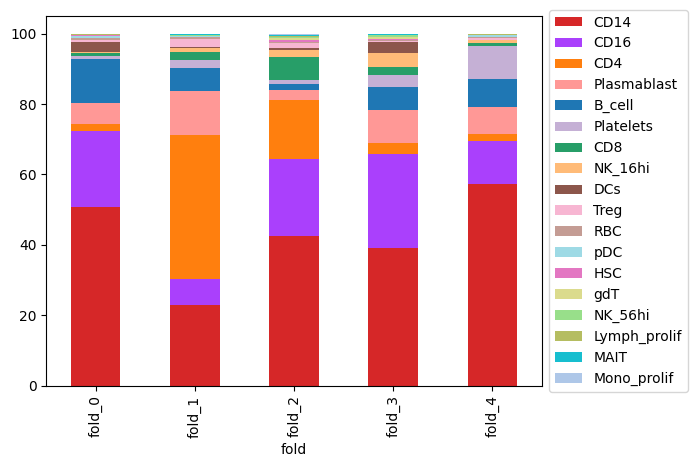

In [50]:
df_group.unstack()[list(df_sort.index)].plot.bar(stacked=True, color=color).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.savefig('figures/attn_robustness_across_folds_mtm_seed_123.svg', bbox_inches='tight')